In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from matplotlib import cm
import copy
from autograd import grad # autodiff for gradient computation
from PIL import Image
from scipy.signal import find_peaks

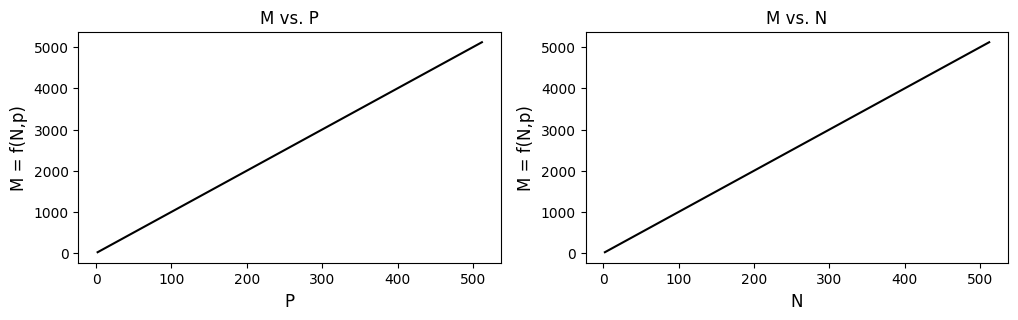

In [11]:
# Problem 1
# Find min of g(w) where w is N-dim vector with range [0,1]
# Use global opt based on 1) regular, or 2) random grid search
# => P points are constructed for each component of W


# Q1) expression for tot. # points (M) to eval g(w); M = f(N, P)
def get_M(N, P):
    return np.array(N)*np.array(P)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot M vs. P for P = [2, 4, 8, 16, 32, ...] and N = 10
P = [2**x for x in range(1, 10)]
N = [10] * len(P)
M = get_M(N, P)
ax1.plot(P, M, 'k')
ax1.set_xlabel('P', fontsize=12)
ax1.set_ylabel('M = f(N,p)', fontsize=12)
ax1.set_title('M vs. P')

# Plot M vs. N for N = [2, 4, 8, 16, 32, ...] and P = 10
N = [2**x for x in range(1, 10)]
P = [10] * len(P)
M = get_M(N, P)
ax2.plot(N, M, 'k')
ax2.set_xlabel('N', fontsize=12)
ax2.set_ylabel('M = f(N,p)', fontsize=12)
ax2.set_title('M vs. N')

plt.show()

/var/folders/_8/nks3d0kn12j1p9b5_zyc49k40000gn/T/ipykernel_53779/4056273841.py:29: RuntimeWarning: divide by zero encountered in divide
  ratio = cd / cs


Text(0.5, 1.0, 'CD / CS with N = 1000')

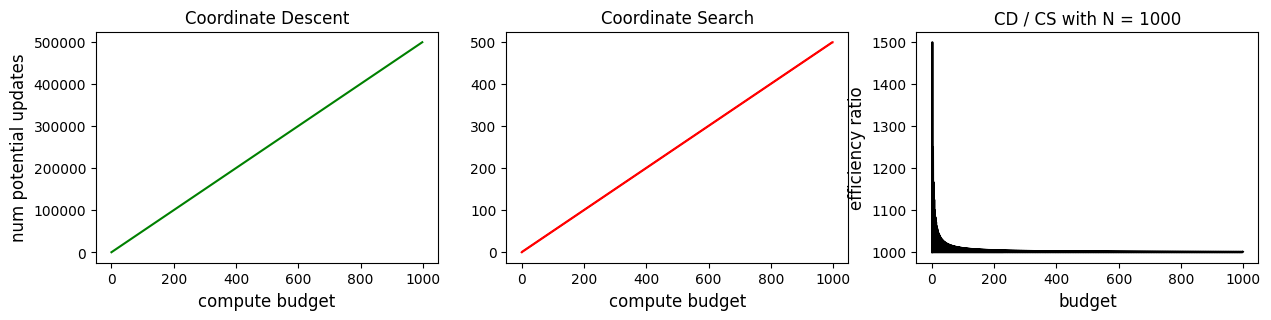

In [46]:
# Q2) Compute cost of coordinate search (CS) vs. coordinate descent (CD)

# constrains...
# - S evaluations of g(w) are allowed

# which approach does more potential updates to w?
# ratio = n_updates_w_higher / n_updates_w_lower
# NOTE: step != potential update to w. step happens iff potential update reduces g(w)


# CS: every 2N eval of g(w) => 1 update ==> /2N
# CD: every 2 eval of g(w) => N updates ==> /2
# ratio = N

def n_potential_updates(S, N, mode):
    if mode == 'CS':
        return S // (2*N)
    elif mode == 'CD':
        return S // 2

# plot ratio vs. S
# S = [N, 2N, ...]
N = 1000
S = np.arange(1, 1000) * N # multiples of N

cs = n_potential_updates(S, N, 'CS')
cd = n_potential_updates(S, N, 'CD')

ratio = cd / cs
ratio

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# growth curves for cd and cs
ax1.plot(cd, 'g')
ax1.set_xlabel('compute budget', fontsize=12)
ax1.set_ylabel('num potential updates', fontsize=12)
ax1.set_title('Coordinate Descent')

ax2.plot(cs, 'r')
ax2.set_xlabel('compute budget', fontsize=12)
ax2.set_title('Coordinate Search')


# Plot M vs. N for N = [2, 4, 8, 16, 32, ...] and P = 10
ax3.plot(ratio, 'k')
ax3.set_xlabel('budget', fontsize=12)
ax3.set_ylabel('efficiency ratio', fontsize=12)
ax3.set_title('CD / CS with N = {}'.format(N))
